# imports

In [15]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, make_scorer
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut

import warnings
warnings.filterwarnings('ignore')

# Dataset

Choose any dataset you like for the classification task on openml.org. 

The selected data set must contain at least 100 objects and at least three classes. 

Remember to vectorize the attributes of your data set (move from categories to numbers), fill in the blanks (if any), and normalize.

# Reduction to the regression problem

Go from the classification task to the regression task in two different ways:

1. The naive way. 

Each class value is represented by a single number. 
During the prediction, the response received is rounded to the nearest integer.

2. Using OneHot encoding.

Instead of a single target attribute, as many new numerical variables are added to the dataset as there are classes in it.


# Hyperparameter tuning

For each of the transforms (naïve and one-hot), find the best combination of distance, kernel functions and window (fixed and neighbor-dependent) for the nearest neighbor method. 

For the best transform and combination found, plot the F-measure as a function of the number of nearest neighbors or the width of the window (dependent on the type of the window). 

Use the Leave-One-Out cross-validation to calculate the F-measure.

# parameters

In [58]:
parameters = {"n_neighbors": range(1, 11),
              "weights": ['uniform', 'distance'],
              "metric": ['euclidean','minkowski','mahalanobis','seuclidean']
              }
test_size = .01

# Common functions

In [17]:
# devide data into X,y and one-hot trasformation
def get_data(df, one_hot=False):
    X = df.loc[:, ~df.columns.isin(['Class'])]
    y = df['Class']
    X = MinMaxScaler().fit_transform(X=X)
    if one_hot:
        encoder = OneHotEncoder(categories='auto')
        dfonehot = pd.DataFrame(encoder.fit_transform(df['Class'].values.reshape(-1, 1)).toarray())
        X = np.concatenate([X, dfonehot.values], axis=1)
    return X, y

In [18]:
# plot tsne on input raw or one-hot transformed data
def display_tsne(X, y):
    tsne = TSNE()
    Y = tsne.fit_transform(X)
    sns.scatterplot(Y[:, 0], Y[:, 1], hue=y, legend='full')
    plt.show()

In [61]:
# depricated!
def plot_f1_measures(df, weights, metric, one_hot=False):

    X, y = get_data(df, one_hot)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    k_range = range(1, 11)
    knn = KNeighborsRegressor()
    loo=LeaveOneOut()
    f1 = make_scorer(f1_score, average='macro')

    f1_scores = []
    for k in k_range:
        param_grid = [{'n_neighbors': [k], 'weights': [weights], 'metric': [metric]}]
        grid = GridSearchCV(knn, param_grid, cv=loo, scoring=f1)
        grid.fit(X_train, y_train)
        
        # y_pred = grid.predict(X_test)
        # print('best_score_', grid.best_score_)
        f1_scores.append(grid.best_score_)
        # print(grid.cv_results_)

        # f1_scores.append(f1_score(y_test, y_pred, average='samples'))
        # print(f1_scores)
        # f1_scores.append(scores.mean())
        # print(k_scores)
        grid_mean_scores = [result.mean_validation_score for result in grid.cv_results_]
        print(grid_mean_scores)
        
    data = {"f1_score": f1_scores}
    sns.lineplot(data=data, x=k_range, y=grid.best_score_)
    plt.xlabel('Value of K for KNeighborsRegressor')
    plt.ylabel('LOO Cross-Validated f1-score')
    plt.show()

    # for n in k:
    #     algorithm = KNeighborsRegressor()
    #     candidates = [{'n_neighbors': [n], 'weights': [weights], 'metric': [metric]}]
    #     loo=LeaveOneOut()
    #     grid = GridSearchCV(estimator=algorithm, param_grid=candidates, cv=loo) 
    #     grid.fit(X_train, y_train)

    #     pred = grid.predict(X_test)
    #     f1_scores.append(f1_score(y_test, [int(x) for x in pred], average='weighted'))

    #     # loo = LeaveOneOut()
    #     # for train, test in loo.split(df):
    #     #     X_train, y_train = get_data(train, one_hot)
    #     #     X_test, y_test = get_data(test, one_hot)
    #     #     clf = KNeighborsRegressor(n_neighbors=n, weights=weights, metric=metric)
    #     #     clf.fit(X_train, y_train)
    #     #     pred = clf.predict(X_test)

    #     #     f1_scores.append(f1_score(y_test, [int(x) for x in pred], average='weighted'))
    # data = {"f1_score": f1_scores}
    # sns.lineplot(data=data, x=k, y=f1_scores)
    # plt.show()

In [127]:
# get loo based f1-score and plot the f1-score with variant neighbors count and fixed best hyperparameters
def plot_loo_f1_measures(df, weights, metric, one_hot=False):

    X, y = get_data(df, one_hot)

    k_range = range(1, 11)
    knn = KNeighborsRegressor()
    loo=LeaveOneOut()
    data = []

    for k in k_range:
        f1_scores = []
        for train_index, test_index in loo.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train = y[train_index]
            y_test = y[test_index]

            param_grid = [{'n_neighbors': [k], 'weights': [weights], 'metric': [metric]}]
            grid = GridSearchCV(knn, param_grid)
            grid.fit(X_train, y_train)
            
            y_pred = grid.predict(X_test)
            f1 = f1_score([y_test], [y_pred], average='macro')
            f1_scores.append(f1)
        data.append(np.mean(f1_scores))

    dataf = {"f1_score": data}
    sns.lineplot(data=dataf, x=k_range, y=data)
    plt.xlabel('Value of K for KNeighborsRegressor')
    plt.ylabel('LOO Cross-Validated f1-score')
    plt.show()


# Naive

In [20]:
# naive algorithm for fixed neighbors count and fixed hyperparameters
def naive(df, k=3):
    X, y = get_data(df)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    print("train size: ", X_train.shape)
    print("test size: ", X_test.shape, "\n")
    
    clf = KNeighborsRegressor(n_neighbors=k)

    clf.fit(X_train, y_train)
    pred = [int(x) for x in clf.predict(X_test)]
    print(f"Predicted class: {pred} (check {y_test.values})")
    print(f"Score {clf.score(X_test, y_test)}")
    print('Mean squared error: %.2f'
          % mean_squared_error(y_test, pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.2f'
          % r2_score(y_test, pred))

In [128]:
# naive algorithm for variant neighbors count and variant hyperparameters with plots
def naive_with_hyperparameters_tuning(df):
    X, y = get_data(df)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    gridsearch = GridSearchCV(KNeighborsRegressor(), parameters) #, verbose=3
    gridsearch.fit(X_train, y_train)
    print(f"Best parameters {gridsearch.best_params_}")

    best_metric = gridsearch.best_params_['metric']
    best_weights = gridsearch.best_params_['weights']

    train_mse = mean_squared_error(y_train, gridsearch.predict(X_train))
    train_rmse = math.sqrt(train_mse)
    print(f"Train rmse {train_rmse}")
    test_preds_grid = gridsearch.predict(X_test)
    test_mse = mean_squared_error(y_test, test_preds_grid)
    test_rmse = math.sqrt(test_mse)
    print(f"Test rmse {test_rmse}")
    print(f"F measure {f1_score(y_test, [int(x) for x in test_preds_grid], average='weighted')}")
    print(classification_report(y_test, test_preds_grid.astype("int8")))
    display_tsne(X, y)
    plot_loo_f1_measures(df, best_weights, best_metric, one_hot=False)

In [22]:
df = pd.read_csv("php44ZCDh.csv")
print("Dataset size:", df.shape)

Dataset size: (117, 91)


In [23]:
naive(df, k=1)

train size:  (115, 90)
test size:  (2, 90) 

Predicted class: [2, 1] (check [2 1])
Score 1.0
Mean squared error: 0.00
Coefficient of determination: 1.00


Best parameters {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Train rmse 0.0
Test rmse 0.0
F measure 1.0
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



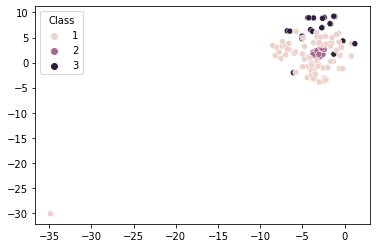

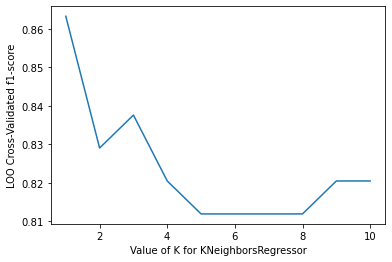

In [129]:
naive_with_hyperparameters_tuning(df)

# One-hot encoding

In [48]:
# one-hot algorithm for fixed neighbors count and fixed hyperparameters
def one_hot(df, k=1):
    X, y = get_data(df, one_hot=True)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    print("train size: ", X_train.shape)
    print("test size: ", X_test.shape, "\n")
    
    clf = KNeighborsRegressor(n_neighbors=k)

    clf.fit(X_train, y_train)
    pred = [int(x) for x in clf.predict(X_test)]
    print(f"Predicted class: {pred} (check {y_test.values})")
    print(f"Score {clf.score(X_test, y_test)}")
    print('Mean squared error: %.2f'
          % mean_squared_error(y_test, pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.2f'
          % r2_score(y_test, pred))

In [112]:
# one-hot algorithm for variant neighbors count and variant hyperparameters with plots
def one_hot_with_hyperparameters_tuning(df):
    X, y = get_data(df, one_hot=True)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    gridsearch = GridSearchCV(KNeighborsRegressor(), parameters, return_train_score=True) #, verbose=3
    gridsearch.fit(X_train, y_train)
    print(f"Best parameters {gridsearch.best_params_}")

    best_metric = gridsearch.best_params_['metric']
    best_weights = gridsearch.best_params_['weights']

    train_mse = mean_squared_error(y_train, gridsearch.predict(X_train))
    train_rmse = math.sqrt(train_mse)
    print(f"Train rmse {train_rmse}")
    test_preds_grid = gridsearch.predict(X_test)
    test_mse = mean_squared_error(y_test, test_preds_grid)
    test_rmse = math.sqrt(test_mse)
    print(f"Test rmse {test_rmse}")
    print(f"F measure {f1_score(y_test, [int(x) for x in test_preds_grid], average='weighted')}")
    print(classification_report(y_test, test_preds_grid.astype("int8")))

    display_tsne(X, y)
    plot_loo_f1_measures(df, best_weights, best_metric, one_hot=True)

In [49]:
one_hot(df)

train size:  (115, 93)
test size:  (2, 93) 

Predicted class: [1, 2] (check [1 2])
Score 1.0
Mean squared error: 0.00
Coefficient of determination: 1.00


Best parameters {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
Train rmse 0.0
Test rmse 0.0
F measure 1.0
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         2

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



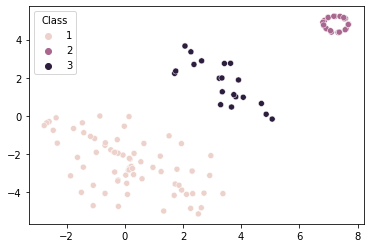

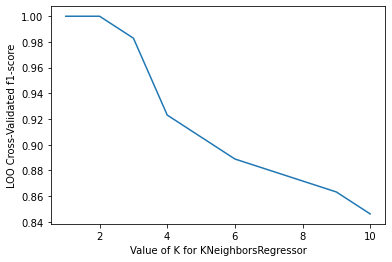

In [130]:
one_hot_with_hyperparameters_tuning(df)